# Movie 1
## Load movie frames and perform segmentations

In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
import cv2

movie1_path = "movies/movie1.avi"

In [2]:
# Find contours and get the largest contour to represent the entire structure
# Get bounding rectangle of leftmost and rightmost sides
def get_bounding_boxes(img):
    contours, hierarchy = cv2.findContours(img, 1, 2)
    c = max(contours, key=cv2.contourArea)
    
    leftBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmin()])
    rightBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmax()])

    return leftBoundingRect, rightBoundingRect, c

## Movie 1 Segmentation and fluorescent intensity measurement

#### Segmentation
- The original movie has text labels. I first crop out the text by creating a blank canvas and slicing onto it the section of the original movie with the structure. I used the first frame to determine the region of interest frame[35:90, :]
- I then convert the resulting canvas frame to grayscale, threshold and blur it to make the thin lines more prominent for easy edge detection
- I used OpenCV's findContours to get the largest contour by area. this should give the contours of the entire structure.
- I then get the bounding rectangle of the leftmost and rightmost ends (trailing and leading respectively)

#### Trailing and Leading edge detection and Intensity measurement
- The bounding rectangle's x and y values allows me to extract the pixels from the original grayscale image in order to measure the intensity using opencv's mean function
- The fluorescent intensity is therefore a measure of the average grayscale pixel value of the leading or trailing edge
- The intensity values are appended as a list to an empty list which will then be converted to a pandas dataframe for visualization

#### Saving segmented file 
- The segmented frames are written into output.avi of the current working directory at 1 frame per second

#### Objections
- The trailing and leading edge detections were inaccurate on frame 5 and on frame 9. That explains the fluctuations in the intensities at those frames in the Fluorescent intensity plot

In [3]:
# Capture movie
cap = cv2.VideoCapture(movie1_path)


# Get movie frame size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
frame_size = (width,height)

# Initialize video writer to save segmented movie at 1 frame per second
writer = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*"XVID"), 1.0, frame_size)

frame_index = 0 # Track frame number for fluorescent intensity table

fluorescent_intensities = []

while True:
    frame_index += 1
    success, frame = cap.read()

    if success and frame.size != 0:
        # Crop frame to remove text
        canvas = np.ones((frame.shape), np.uint8)
        canvas[35:90, :] = frame[35:90, :]
        
        # Blur to fill threshold gaps
        gray_frame = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
        _, imgThreshold = cv2.threshold(gray_frame, 15, 255, cv2.THRESH_BINARY)
        blur_frame = cv2.GaussianBlur(imgThreshold, (7,7), 0)

        # Get trailing and leading bounding rectangle, and entire cell contour
        trailing, leading, c = get_bounding_boxes(blur_frame.copy())
        x,y,w,h = cv2.boundingRect(c)

        # cv2.drawContours(canvas, [c], 0, (0, 255, 255), 2)
        tx,ty,tw,th = trailing
        lx,ly,lw,lh = leading
        box_thickness = 20
        
        # Draw leading and trailing rectangles
        cv2.rectangle(canvas, (tx,y), (tx+box_thickness,y+h), (0, 0, 255), 1)
        cv2.rectangle(canvas, (lx,y), (lx-15,y+h), (0, 255, 0), 1)

        # Calculate mean intensity at trailing edge
        trailing_edge = gray_frame[y:y+h, tx:tx+box_thickness]
        trailing_edge_intensity = cv2.mean(trailing_edge)
        # print("Trailing Edge:", trailing_edge_intensity)

        # Calculate mean intensity at leading edge
        leading_edge = gray_frame[y:y+h, lx-15:lx]
        leading_edge_intensity = cv2.mean(leading_edge)
        # print("Leading Edge:", leading_edge_intensity)
        
        # Append intensity data to list
        fluorescent_intensities.append([frame_index, trailing_edge_intensity[0], leading_edge_intensity[0]])

        writer.write(canvas)

        cv2.imshow("Movie 1 segments", canvas)

    # 1 frame per second
    if cv2.waitKey(1000) & 0xFF == ord('q'):
        break

cap.release()
writer.release()
cv2.destroyAllWindows()

## Convert intensity values into data frame

In [4]:
import pandas as pd
intensity_dataframe = pd.DataFrame(fluorescent_intensities, columns =  ["Frame", "Trailing", "Leading"])
intensity_dataframe

,Frame,Trailing,Leading
0,1,21.215455,9.323636
1,2,24.148113,11.825157
2,3,24.315385,10.791026
3,4,22.311321,10.129560
4,5,6.210185,9.332099
5,6,24.129412,12.661438
6,7,25.930392,13.354248
7,8,26.800000,14.130719
8,9,8.593137,10.394771
9,10,22.766667,10.505882


## Plot intensity values

<IPython.core.display.Javascript object>


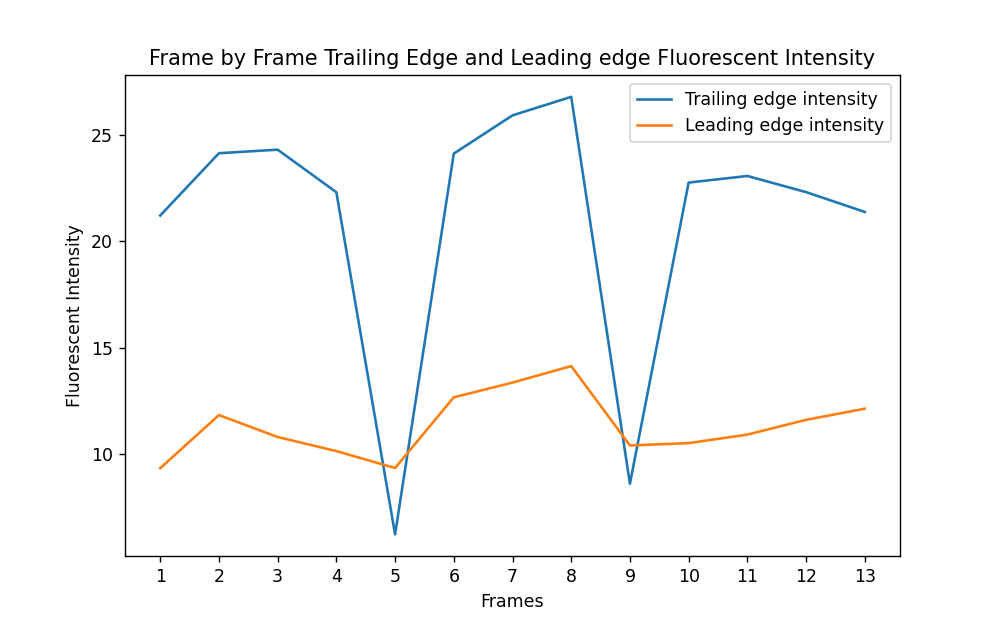

In [5]:
plt.figure(figsize=(8,5))
plt.plot(intensity_dataframe.Frame, intensity_dataframe.Trailing, label="Trailing edge intensity")
plt.plot(intensity_dataframe.Frame, intensity_dataframe.Leading, label="Leading edge intensity")

plt.title("Frame by Frame Trailing Edge and Leading edge Fluorescent Intensity")
plt.ylabel("Fluorescent Intensity")
plt.xlabel("Frames")
plt.legend()
plt.xticks(intensity_dataframe.Frame)
plt.show()